In [1]:
from scipy import special
import matplotlib.pyplot as plt
from scipy import linalg
import numpy as np
from svgutils import compose as sc

In [2]:
import sys
sys.path.append('../libs/')

In [3]:
import ei_model.mean_field_model as mf
from ei_model.model_parameters import *
from ei_model.units import *

import ei_model.synchrony_analysis as sa

In [4]:
import attr

In [5]:
@attr.s
class SquareWave:
    delay = attr.ib(10.)
    period = attr.ib(1. * s)
    duration = attr.ib(0.35 * s)
    amplitude = attr.ib(1000 * Hz)
    
    def square_wave(self, t):
        return (self.amplitude * 
                (np.mod(t, self.period) < self.duration) *
                (t > self.delay))

    def step(self, dt, state, **kwargs):
        rate, time = state
        time += dt
        rate = self.square_wave(time)
        return np.array([rate, time])
        

In [6]:
glutamate = SquareWave(period=5 * s, delay=0)
glutamate.step(1*ms, [0, 0.])

array([  1.00000000e+03,   1.00000000e-03])

In [7]:
from collections import namedtuple
Stats = namedtuple('Stats', ['mean', 'stderr', 'n'])

def get_statistics(values):
    mean = np.mean(values)
    n = len(values)
    if n < 2: 
        std = np.nan
    else:
        std = np.std(values)

    stderr = std / np.sqrt(n)
    
    return Stats(mean, stderr, n) 

def print_statistics(stats):
    mean, stderr, n = stats
    print("{:.3f} +/- {:.3f} (n={})".format(mean, stderr, n))

In [8]:
tmax = 500 * s


## One-dimensional

In [9]:
models_chain = [glutamate, model, model, model]
initial_conditions_chain = [np.zeros(2), 
                      np.array([100 * Hz, 100 * Hz, 0]),
                      np.array([100 * Hz, 100 * Hz, 0]),
                      np.array([100 * Hz, 100 * Hz, 0]),
                     ]

In [10]:
C_field_chain = linalg.toeplitz([0, 1, 0, 0]) * gamma_ephaptic
C_field_chain[:, 0] = np.zeros(4)
C_field_chain[0, :] = np.zeros(4)


C_rate_chain = np.zeros((4, 4))
C_rate_chain[:, 0] = [0, 1, 0, 1]
C_rate_chain[0, :] = [0, 0, 0 ,0]

In [11]:
def plot_connectivity(C_field, C_rate):
    fig_connectivity = plt.figure(figsize=(2,5))
    fig_connectivity.subplots_adjust(hspace=0)
    ax1 = plt.subplot(211)
    plt.spy(C_field[1:, 1:])
    ax1.set_title('ephaptic coupling')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_xlabel('populations')
    ax1.set_ylabel('populations')
    ax2 = plt.subplot(212)
    plt.spy(C_rate[None, 1:, 0])
    ax2.set_title('external stimulation')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_yticks([])
    ax2.set_xlabel('populations')
    return fig_connectivity

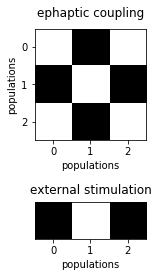

In [12]:
fig_connectivity_chain = plot_connectivity(C_field_chain, C_rate_chain)


In [13]:
time, states_chain = mf.ephaptically_coupled_network(dt, tmax,
                                               models_chain,
                                               initial_conditions_chain,
                                               C_field_chain, C_rate_chain)

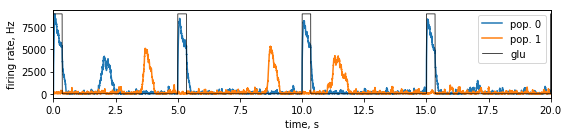

In [14]:
fig_traces = plt.figure(figsize=(8, 2))
l1, = plt.plot(time[time<20*s], states_chain[1][time<20*s, 1])
l2, = plt.plot(time[time<20*s], states_chain[2][time<20*s, 1])
plt.xlabel('time, s')
plt.ylabel('firing rate, Hz')
plt.xlim((0, 20))
plt.twinx()
l3, = plt.plot(time[time<20*s], states_chain[0][time<20*s, 0], 'k', lw=0.7)
plt.yticks([])
plt.legend((l1,l2,l3), ['pop. 0', 'pop. 1', 'glu'])
plt.tight_layout()
#fig_traces.savefig('../figures/glu_protocol_traces.svg')

In [15]:
solution_chain = np.array([s[:, 0] for s in states_chain[1:]]).T

In [16]:
pli_chain = sa.calc_pli(solution_chain, dt)

In [17]:
pli_chain_receiver = np.array([pli_chain[0, 1], pli_chain[2, 1]])
pli_chain_receiver_stats = get_statistics(pli_chain_receiver)
print_statistics(pli_chain_receiver_stats)

0.249 +/- 0.001 (n=2)


In [18]:
pli_chain_stimed = [pli_chain[0, 2]]
pli_chain_stimed_stats = get_statistics(pli_chain_stimed)
print_statistics(pli_chain_stimed_stats)

0.559 +/- nan (n=1)


Text(0, 0.5, 'populations')

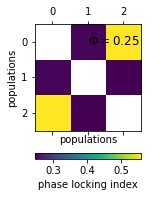

In [19]:
fig_pli_chain = plt.figure(figsize=(2.8,2.8))
ax = plt.subplot(111)
m = ax.matshow(pli_chain)
cbar = plt.colorbar(m, orientation='horizontal', shrink=0.68)
cbar.set_label('phase locking index')
ax.text(0.5, 0.8, '$\\bar{{\Phi}}={:.2f}$'.format(pli_chain_receiver_stats.mean),
        size=12,
        color='k',
        transform=ax.transAxes)
ax.set_xlabel('populations')
ax.set_ylabel('populations')

In [20]:
svg = sc.Figure("9cm", "9.5cm",
                sc.SVG('chain_glu.svg').move(40, 40),
                sc.MplFigure(fig_connectivity_chain).move(180, 0),
                sc.MplFigure(fig_pli_chain).move(-10, 100),
                sc.Text("A", weight='bold', size=18).move(20,20),
                sc.Text("B", weight='bold', size=18).move(170,20),
                sc.Text("C", weight='bold', size=18).move(20,110)


               )
# svg.save('../figures/glu_protocol_chain.svg')
svg

**Figure** Ephaptic entrainment to synchronous oscillations by synchronised neighbours. **A**. One-dimensional chain of E/I populations. Populations in black are forced to synchronous oscillations by external stimulation. Ephaptic interactions are only between direct neighbours. **B**. Connectivity matrix of populations coupled by electric field (top) and populations receiving external stimulation (bottom). **C**. Pairwise phase locking index (PLI) between all pairs of populations. The value in the top right corners gives the PLI between population "1" and its neigbours.

## Two-dimensional

In [21]:
models_hex = [glutamate] + [model] * 7
model_ic = list(np.tile(np.array([100 * Hz, 100 * Hz, 0]), [7, 1]))
initial_conditions_hex = [np.zeros(2)] + model_ic

In [22]:
C_field_hex = np.zeros((8, 8))
C_field_hex[1:-1, 1:-1] = linalg.circulant([0,1, 0, 0,0, 1])#linalg.toeplitz([0, 1, 0, 0, 0, 0, 0, 0]) * gamma_ephaptic
C_field_hex[-1, 1:-1] = 1
C_field_hex[1:-1, -1] = 1
C_field_hex = C_field_hex * gamma_ephaptic

C_rate_hex = np.zeros((8, 8))
C_rate_hex[:, 0] = [0, 1, 1, 1, 1, 1, 1, 0]
C_rate_hex[0, :] = np.zeros(8)

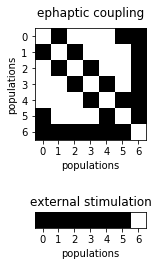

In [23]:
fig_connectivity_hex = plot_connectivity(C_field_hex, C_rate_hex)

In [24]:
time, states_hex = mf.ephaptically_coupled_network(dt, tmax,
                                               models_hex,
                                               initial_conditions_hex,
                                               C_field_hex, C_rate_hex)

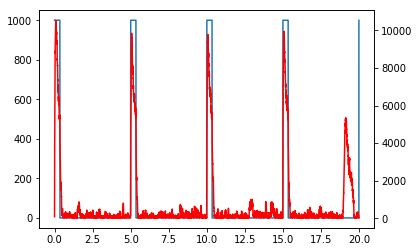

In [25]:
plt.figure()
plt.plot(time[time<20*s], states_hex[0][time<20*s, 0])
plt.twinx()
plt.plot(time[time<20*s], states_hex[2][time<20*s, 1], 'r')

In [26]:
solution_hex = np.array([s[:, 0] for s in states_hex[1:]]).T

In [27]:
pli_hex = sa.calc_pli(solution_hex, dt)

In [28]:
pli_hex_receiver = pli_hex[:-1, -1]
pli_hex_receiver_stats = get_statistics(pli_hex_receiver)
print_statistics(pli_hex_receiver_stats)

0.351 +/- 0.008 (n=6)


In [29]:
pli_hex_stimed = pli_hex[:-1, :-1]
pli_hex_stimed = np.extract(~np.tri(6, dtype=bool), pli_hex_stimed)
pli_hex_stimed_stats = get_statistics(pli_hex_stimed)
print_statistics(pli_hex_stimed_stats)

0.560 +/- 0.007 (n=15)


Text(0, 0.5, 'populations')

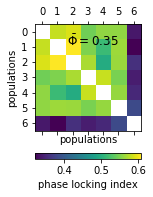

In [30]:
fig_pli_hex = plt.figure(figsize=(2.8,2.8))
ax = plt.subplot(111)
m = ax.matshow(pli_hex)
cbar = plt.colorbar(m, orientation='horizontal', shrink=0.68)
cbar.set_label('phase locking index')
ax.text(0.3, 0.8, '$\\bar{{\Phi}}={:.2f}$'.format(pli_hex_receiver_stats.mean),
        size=12,
        color='k',
        transform=ax.transAxes)
ax.set_xlabel('populations')
ax.set_ylabel('populations')

In [31]:
svg = sc.Figure("9cm", "9.5cm",
                sc.SVG('hexagon_glu.svg').scale(0.5).move(40, 20),
                sc.MplFigure(fig_connectivity_hex).move(180, 0),
                sc.MplFigure(fig_pli_hex, transparent=True).move(-10, 130),
                sc.Text("A", weight='bold', size=18).move(20,20),
                sc.Text("B", weight='bold', size=18).move(170,20),
                sc.Text("C", weight='bold', size=18).move(20,140)


               )
# svg.save('../figures/glu_protocol_hex.svg')
svg

**Figure** Ephaptic entrainment to synchronous oscillations by synchronised neighbours. **A**. Two-dimensional hexagonal network of E/I populations. Populations in black are forced to synchronous oscillations by external stimulation. Ephaptic interactions are only between direct neighbours. **B**. Connectivity matrix of populations coupled by electric field (top) and population receivings external stimulation (bottom, black squares). **C**. Pairwise phase locking index (PLI) between all pairs of populations. The value in the top right corners gives the PLI between population "6" and its neigbours.

## Compare PLIs

In [32]:
def despine(ax=None):
    if ax is None: ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_position(('outward', 20))

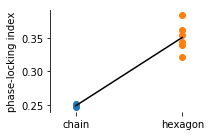

In [33]:
fig = plt.figure(figsize=(3,2))
jitter = 0.
plt.plot(np.zeros(len(pli_chain_receiver)), pli_chain_receiver, 'o')
plt.plot(np.ones(len(pli_hex_receiver)) + 
         jitter * np.random.randn(len(pli_hex_receiver)), 
         pli_hex_receiver, 'o')

plt.plot([pli_chain_receiver_stats.mean,
          pli_hex_receiver_stats.mean], color='k')
despine()
plt.xticks([0, 1], ['chain', 'hexagon'])
plt.ylabel('phase-locking index')
plt.tight_layout()
# plt.savefig('../figures/glu_protocol_pli.svg')

**Figure** Comparison of phase-locking indices between the "entrained" population and its neighbours in one-dimensional chain topology (chain) and two-dimensional hexagonal topology (hexagon). The individual PLIs for each pair are shown with dots, the black line connects the means.